In [ ]:
import torch
import pandas as pd
import numpy as np
import random
import yaml
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from transformers import ViTForImageClassification, ViTFeatureExtractor
from PIL import Image
from sklearn.decomposition import PCA
from scipy.spatial.distance import mahalanobis
from scipy.linalg import inv
import os
import shutil

from sklearn.metrics.pairwise import cosine_distances


In [ ]:
checkpoint_path = "checkpoints/baseline_vit.pth"
root_dir = 'D:/dataset/_eyepacs/data/ochisheni_no_yarkosti/train'
# Загрузка настроек
with open('parametrs.yaml', 'r', encoding='utf-8') as f:
    config = yaml.safe_load(f)

# Установка сидов
seed = config['experiment']['seed']
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)


# Загружаем модель и параметры
device = torch.device(config['training']['device'] if torch.cuda.is_available() else "cpu")
num_epochs = config['training']['num_epochs']
batch_size = config['training']['batch_size']
learning_rate = config['training']['learning_rate']
early_stopping_patience = config['training']['patience']


In [ ]:
def get_transform_pipeline(config, label=None):
    transform_list = []

    # Только resize — как базовая подготовка изображения
    transform_list.append(transforms.Resize(config['dataset']['image_size']))

    # Преобразование в тензор и нормализация
    transform_list.extend([
        transforms.ToTensor(),
        transforms.Normalize(mean=config['dataset']['mean'], std=config['dataset']['std'])
    ])

    return transforms.Compose(transform_list)


In [ ]:
# Feature Extractor для ViT
class FundusDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, root_dir, config):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.config = config

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_name = row['image_name']
        label = int(row['true_label'])
        img_path = os.path.join(self.root_dir, str(label), img_name)
        image = Image.open(img_path).convert("RGB")
        
        transform = get_transform_pipeline(self.config, label=label)
        image = transform(image)

        return image, label, img_name


In [ ]:
train_csv = config['dataset']['train_csv']
train_df = pd.read_csv(train_csv)
train_dataset = FundusDataset(train_df, root_dir=root_dir, config=config)
train_loader = DataLoader(train_dataset, batch_size=config['training']['batch_size'], shuffle=False)


In [ ]:
def get_image_path(row):
    class_folder = str(row['true_label'])
    return os.path.join(train_data_dir, class_folder, row['image_name'])

train_df['image_path'] = train_df.apply(get_image_path, axis=1)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


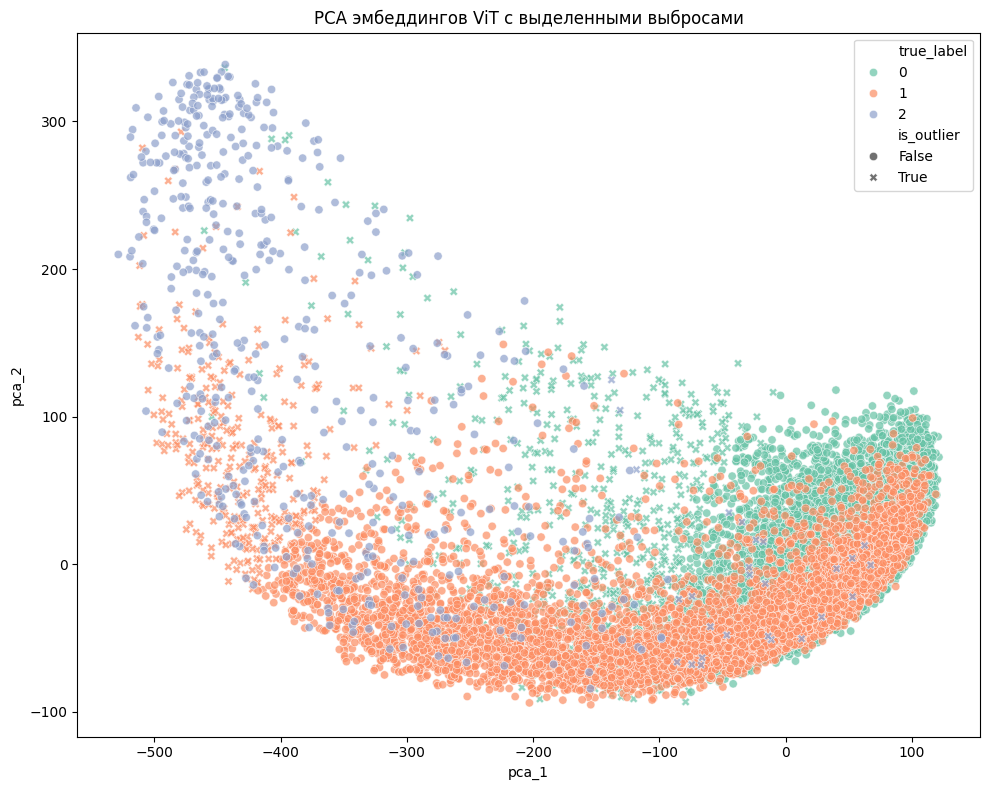

Процесс завершён. Изображения с выбросами перемещены в папку 'cosine_trash'.


In [3]:
import os
import numpy as np
import pandas as pd
import torch
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_distances
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import shutil
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification
from PIL import Image
import yaml
import random
from torchvision import transforms

# === Загрузка настроек ===
with open('parametrs.yaml', 'r', encoding='utf-8') as f:
    config = yaml.safe_load(f)

# === Установка сидов ===
seed = config['experiment']['seed']
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# === Устройство ===
device = torch.device(config['training']['device'] if torch.cuda.is_available() else "cpu")

# === Загрузка модели ViT ===
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=3)
checkpoint_path = "checkpoints/baseline_vit.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.to(device)
model.eval()


# === Датасет и загрузчик ===
class FundusDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, root_dir, config):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.config = config

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_name = row['image_name']
        label = int(row['true_label'])
        img_path = os.path.join(self.root_dir, str(label), img_name)
        image = Image.open(img_path).convert("RGB")
        
        transform = get_transform_pipeline(self.config, label=label)
        image = transform(image)

        return image, label, img_name

def get_transform_pipeline(config, label=None):
    transform_list = []
    transform_list.append(transforms.Resize(config['dataset']['image_size']))
    transform_list.extend([transforms.ToTensor(), transforms.Normalize(mean=config['dataset']['mean'], std=config['dataset']['std'])])
    return transforms.Compose(transform_list)

# Загрузка данных
train_csv = config['dataset']['train_csv']
train_df = pd.read_csv(train_csv)
root_dir = 'D:/dataset/_eyepacs/data/ochisheni_no_yarkosti/train'

train_dataset = FundusDataset(train_df, root_dir=root_dir, config=config)
train_loader = DataLoader(train_dataset, batch_size=config['training']['batch_size'], shuffle=False)

# === Извлечение эмбеддингов ===
embeddings = []
labels = []
image_paths = []

with torch.no_grad():
    for images, batch_labels, paths in train_loader:
        images = images.to(device)
        outputs = model(pixel_values=images, output_hidden_states=True)
        batch_embeddings = outputs.hidden_states[-1][:, 0, :].cpu().numpy()
        
        embeddings.extend(batch_embeddings)
        labels.extend(batch_labels.numpy())
        image_paths.extend(paths)

embeddings = np.array(embeddings)

# === Центроиды каждого класса ===
centroids = {c: embeddings[labels == c].mean(axis=0) for c in np.unique(labels)}

# === Расчет косинусного расстояния ===
df = train_df.copy()
df['cosine_distance'] = [cosine_distances([e], [centroids[l]])[0][0] for e, l in zip(embeddings, labels)]

# === Выделение выбросов по 95 перцентилю ===
df['is_outlier'] = False
for c in np.unique(labels):
    threshold = np.percentile(df[df['true_label'] == c]['cosine_distance'], 95)
    df.loc[(df['true_label'] == c) & (df['cosine_distance'] > threshold), 'is_outlier'] = True

# === PCA для визуализации ===
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)
df['pca_1'] = pca_result[:, 0]
df['pca_2'] = pca_result[:, 1]

# Визуализация PCA
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='pca_1', y='pca_2', hue='true_label', style='is_outlier', palette='Set2', alpha=0.7)
plt.title("PCA эмбеддингов ViT с выделенными выбросами")
plt.tight_layout()
plt.show()



print("Процесс завершён. Изображения с выбросами перемещены в папку 'cosine_trash'.")


In [6]:
import shutil
from pathlib import Path

# === Создание папок для хранения очищенных данных ===
output_base = Path("D:/dataset/_eyepacs/data/filtered_data_with_cosine")
(train_out := output_base / "train").mkdir(parents=True, exist_ok=True)
(trash_out := output_base / "cosine_trash").mkdir(parents=True, exist_ok=True)

# === Копирование изображений ===
for _, row in df.iterrows():
    # Формируем путь к исходному изображению
    img_name = row['image_name']
    src = Path('D:/dataset/_eyepacs/data/ochisheni_no_yarkosti/train') / str(row['true_label']) / img_name

    # Определяем папку назначения: либо для выбросов, либо для нормальных данных
    dst_folder = trash_out if row['is_outlier'] else (train_out / str(row['true_label']))

    # Создаем папку, если ее нет, и копируем файл
    dst_folder.mkdir(parents=True, exist_ok=True)
    shutil.copy2(src, dst_folder / img_name)

print("Процесс завершен. Изображения с выбросами перемещены в папку 'cosine_trash'.")


Процесс завершен. Изображения с выбросами перемещены в папку 'cosine_trash'.
